In [1]:
from utils.dataloader import QM9Dataset, DataLoader
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from scipy.optimize import least_squares
from scipy.special import softmax
from sklearn.metrics import log_loss
from tqdm import tqdm
import torch
from layers.octetRule import OctetRuleModel
from torch.nn import CrossEntropyLoss

In [2]:
%matplotlib notebook

In [3]:
dataset = 'zinc'

In [90]:
d_train = QM9Dataset(data=f'data/{dataset}/adjacency_matrix_train_scaffold.pkl',num_masks=0)
dl_train = DataLoader(d_train,batch_size=100)
d_test = QM9Dataset(data=f'data/{dataset}/adjacency_matrix_test_scaffold.pkl',num_masks=0)
dl_test = DataLoader(d_test,batch_size=100)

In [91]:
all_atoms = {'atom':[],'length':[]}
for b in iter(dl_train):
    for atoms, length in zip(b.atoms, b.lengths):
        length = length.item()
        
        for atom in atoms:
                all_atoms['atom'] += [atom]
                all_atoms['length'] += [length]
df_train = pd.DataFrame.from_dict(all_atoms)

all_atoms = {'atom':[],'length':[]}
for b in iter(dl_test):
    for atoms, length in zip(b.atoms, b.lengths):
        length = length.item()
        
        for atom in atoms:
                all_atoms['atom'] += [atom]
                all_atoms['length'] += [length]
df_test = pd.DataFrame.from_dict(all_atoms)

<IPython.core.display.Javascript object>


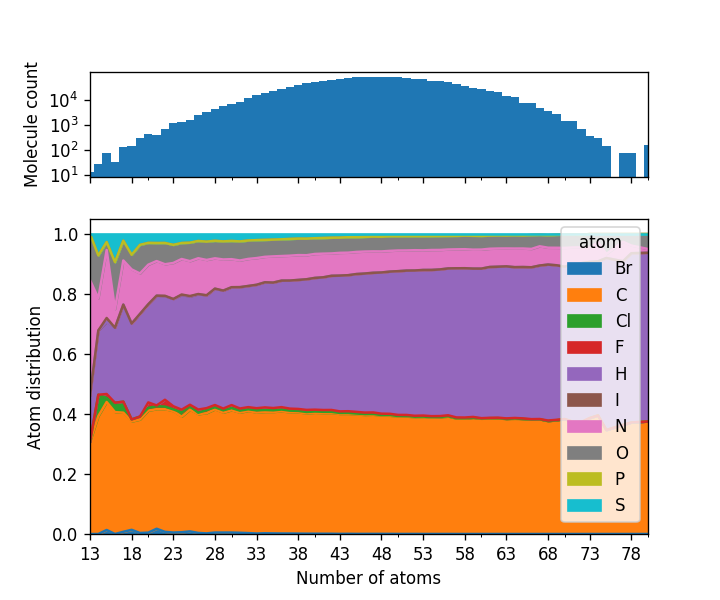

In [49]:
df_test['c']=1
df3 = df_test.groupby(['atom','length']).count().reset_index().pivot(index='length',columns='atom',values='c')

fig, (ax, ax2) = plt.subplots(2,1, sharex=True,figsize=(6,5), gridspec_kw={'height_ratios':[1,3]})
ax.hist(df_test.length,bins=np.arange(4,90)+0.5)
ax.set_ylabel('Molecule count')
ax.set_yscale('log')
ax.set_yticks([1e1,1e2,1e3,1e4])
df3.div(df3.sum(axis=1), axis=0).plot.area(ax=ax2)
ax2.set_ylabel('Atom distribution')
ax2.set_xlabel('Number of atoms')
ax2.set_xticks(np.arange(13,80,5))
ax.set_xticks(np.arange(13,80,5))
plt.savefig(f'distribution_{dataset}_test.pdf')

<IPython.core.display.Javascript object>


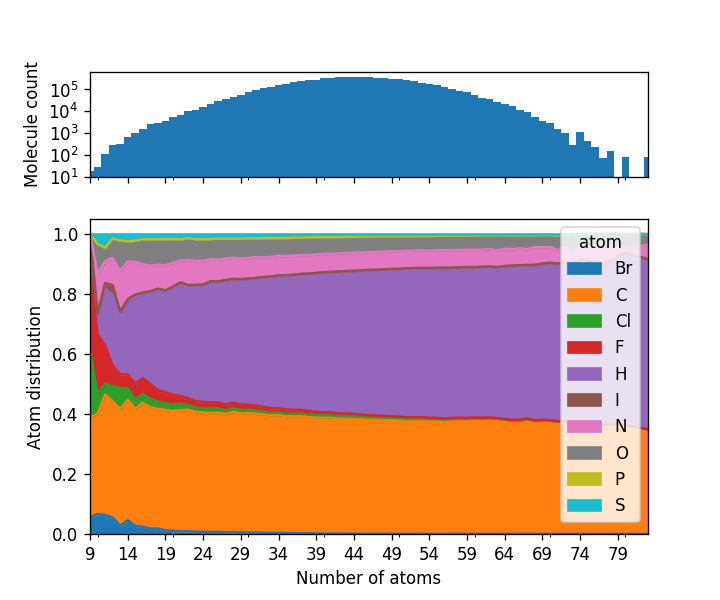

In [53]:
df_train['c']=1
df3 = df_train.groupby(['atom','length']).count().reset_index().pivot(index='length',columns='atom',values='c')

fig, (ax, ax2) = plt.subplots(2,1, sharex=True,figsize=(6,5), gridspec_kw={'height_ratios':[1,3]})
ax.hist(df_train.length,bins=np.arange(4,90)+0.5)
ax.set_ylabel('Molecule count')
ax.set_yscale('log')
ax.set_yticks([1e1,1e2,1e3,1e4,1e5])
df3.div(df3.sum(axis=1), axis=0).plot.area(ax=ax2)
ax2.set_ylabel('Atom distribution')
ax2.set_xlabel('Number of atoms')
ax2.set_xticks(np.arange(df_train.length.min(),df_train.length.max(),5))
ax.set_xticks(np.arange(df_train.length.min(),df_train.length.max(),5))
plt.savefig(f'distribution_{dataset}_train.pdf')

<IPython.core.display.Javascript object>


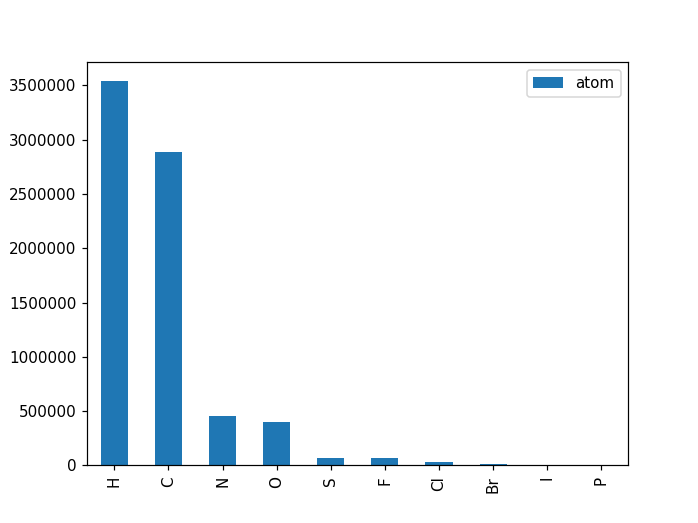

In [92]:
counts = pd.DataFrame(df_train['atom'].value_counts())
counts.plot(kind='bar')
#make sure the order of the atoms is the same as in the dataloader
counts['srt_val'] = [1,2,4,3,7,5,8,9,10,6]
counts = counts.sort_values('srt_val')['atom']

In [93]:
counts/counts.sum()

H     0.474075
C     0.386910
O     0.054162
N     0.061088
F     0.008556
P     0.000012
S     0.009130
Cl    0.004520
Br    0.001440
I     0.000107
Name: atom, dtype: float64

In [66]:
def inverse_softmax(p):

    result = least_squares(lambda x: softmax(x)-p,[0]*len(p),xtol=1e-15,gtol=1e-15,ftol=1e-15)
    return result.x

In [67]:
softmax(inverse_softmax([0.8,0.2]))

array([0.8, 0.2])

In [88]:
# Unigram
inverse_softmax(list(counts/counts.sum()))

,atom
H,0.519182
C,0.347301
O,0.077523
N,0.054189
F,0.001805


In [85]:
#Oktet rule unigram with 1 smoothing
atom_groups = [['H','F','Cl','Br','I'],['O','S'],['N','P'],['C']]

octet_counts = []
for i, atom_group in enumerate(atom_groups):
    tmp = counts.copy()
    tmp[~tmp.index.isin(atom_group)] = 0
    octet_counts += [tmp.atom.to_list()]
    tmp += 1
    print(f"\nGROUP {i+1} : \n")
    print((tmp/tmp.sum()))
    print("\ninverse softmax:")
    #print(inverse_softmax(tmp/tmp.sum()))
    print("\nsanity check:")
    #print(softmax(inverse_softmax(tmp/tmp.sum())))
    
np.asarray(octet_counts)


GROUP 1 : 

       atom
H  0.996531
C  0.000001
O  0.000001
N  0.000001
F  0.003466

inverse softmax:

sanity check:

GROUP 2 : 

       atom
H  0.000008
C  0.000008
O  0.999969
N  0.000008
F  0.000008

inverse softmax:

sanity check:

GROUP 3 : 

       atom
H  0.000011
C  0.000011
O  0.000011
N  0.999956
F  0.000011

inverse softmax:

sanity check:

GROUP 4 : 

       atom
H  0.000002
C  0.999993
O  0.000002
N  0.000002
F  0.000002

inverse softmax:

sanity check:


array([[873518,      0,      0,      0,   3037],
       [     0,      0, 130432,      0,      0],
       [     0,      0,      0,  91173,      0],
       [     0, 584330,      0,      0,      0]])

In [83]:
tmp.atom.to_list()

[1, 584331, 1, 1, 1]

In [4]:
loss_func = CrossEntropyLoss()

d = QM9Dataset(data='data/zinc/adjacency_matrix_validation_scaffold.pkl',num_masks=100)
dl = DataLoader(d,batch_size=1028)

losses = []
for k in tqdm(np.logspace(0,4)):
    model = OctetRuleModel(k=k)
    loss = []
    for b in dl:
        with torch.no_grad():
            output = model(b)

            targets = b.targets_num 
            targets = targets[targets != 0]
            targets -= 1

            loss += [loss_func(output['out'][b.target_mask], targets).item()]
    losses.append(np.mean(loss))

100%|██████████| 50/50 [11:58<00:00, 14.36s/it]


<IPython.core.display.Javascript object>


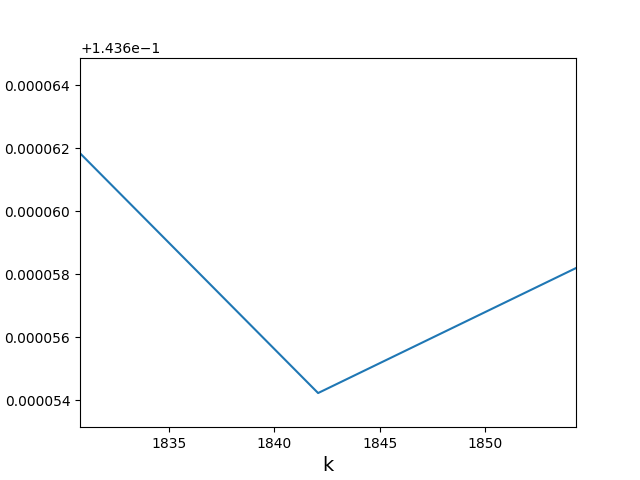

In [17]:
plt.plot(np.logspace(0,4),losses)
plt.xlabel('k',fontsize=14)
plt.ylabel('Cross Entropy',fontsize=14)
plt.annotate('k=1842',xy=(1842,0.143),xytext=(1842,0.15),arrowprops={'arrowstyle':'->'},fontsize=14)
plt.savefig('images/smoothing.pdf')

In [19]:
np.logspace(0,4)[np.argmin(losses)]

1842.0699693267145